### Function: `get_bids(attributes, tasks, num_epochs=100)`

This function implements a bidding process using a neural network model to train agents (or robots) on task allocation based on their attributes. The core idea is to learn how to bid for tasks over multiple epochs and update the bidding model based on rewards and task utility feedback.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
import datetime

from other import *

np.random.seed(1024)

In [2]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [3]:
def get_bids(attributes, tasks, num_epochs=100):
    R, T, A = attributes.shape
    reward_vec = get_rewards(tasks)

    # initialize model
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(A,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    for _ in range(num_epochs):
        # get bids based on model
        bids = np.zeros((R, T))
        for r in range(R):
            for t in range(T):
                a_input = attributes[r, t].reshape(1, A) # added .reshape(1, A)
                # bids[r, t] = model.predict(a_input.reshape(1, -1), verbose=0)
                bids[r, t] = max(0, model.predict(a_input, verbose=0))

        # send bids to allocation function
        allocations = get_allocations(bids, reward_vec) # dictionary with keys 0...r-1 and values are tuples (task, utility)
        print(allocations)

        # update model based on those utilities
        for r in range(R):
            utility = allocations[r][1].reshape(1, 1)
            task = allocations[r][0]
            input = attributes[r, task].reshape(1, A)
            model.fit(input, utility, verbose=0, callbacks=[tensorboard_callback])
    print(bids)
    return model, allocations



notes

try to connect tensorboard to this 
plot reward over time, tensorboard helps do this --> real time trainnig which is way better. 

consider curriculm learning? 
possibly transfer learning would help but often finicky. 

stable baselines? there are lots of out of box models in pso and such. run through 5 or 6 baselines that generally work well.

maybe experience replay is similar to overfitting removal? replacement for regularization. 

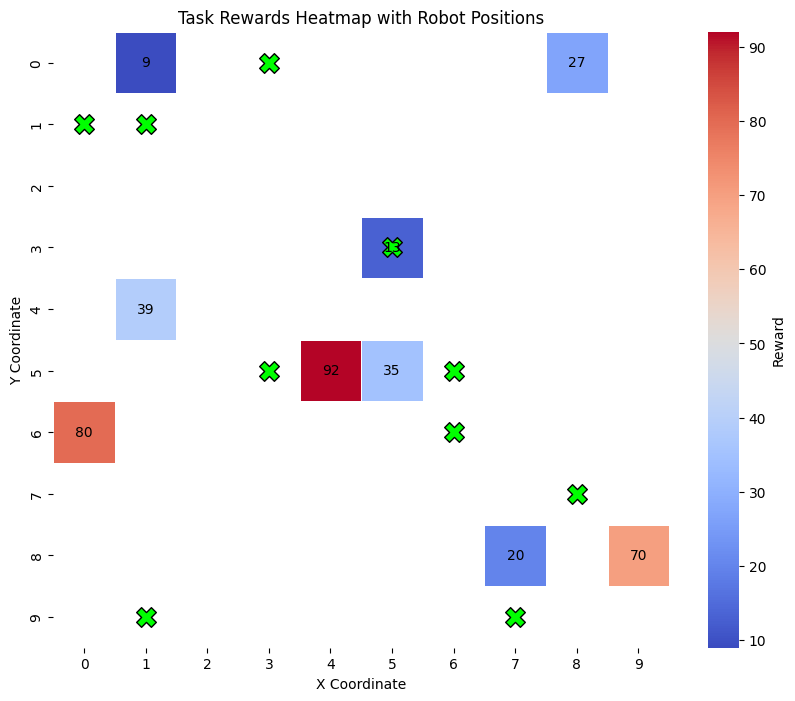

/Users/devg/robopt/.venv/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/var/folders/9r/sw7rn4810sjddctl8q8nlcy80000gn/T/ipykernel_76263/372689631.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bids[r, t] = max(0, model.predict(a_input, verbose=0))


{0: (0, 92.87237060070038), 1: (7, 25.887645959854126), 2: (8, 19.366363286972046), 3: (3, 79.25690096616745), 4: (1, 7.682666897773743), 5: (6, 91.90201630443335), 6: (2, 12.86171843111515), 7: (5, 38.428314208984375), 8: (9, 34.99203221779317), 9: (4, 68.64290249347687)}
{0: (0, 92.20004975795746), 1: (7, 25.208640694618225), 2: (8, 18.951273322105408), 3: (3, 78.79614305496216), 4: (1, 6.941408634185791), 5: (6, 91.71053206920624), 6: (2, 12.653660237789154), 7: (5, 38.032639026641846), 8: (9, 34.88205687701702), 9: (4, 67.84905290603638)}
{0: (0, 91.53462195396423), 1: (7, 24.533416986465454), 2: (8, 18.53451383113861), 3: (3, 78.33857846260071), 4: (1, 6.210262775421143), 5: (6, 91.52156063914299), 6: (2, 12.447436392307281), 7: (5, 37.63513219356537), 8: (9, 34.759890630841255), 9: (4, 67.06519603729248)}
{0: (0, 90.83778834342957), 1: (7, 23.825790882110596), 2: (8, 18.093982100486755), 3: (3, 77.85819125175476), 4: (1, 5.444586277008057), 5: (6, 91.32000148296356), 6: (2, 12.23

KeyboardInterrupt: 

In [4]:
# vars
grid_size = (10, 10)
num_robots = 10
num_tasks = 10
epochs = 100

# init
robots = init_robots(num_robots, grid_size)
tasks = init_tasks(num_tasks, grid_size)
visualize(robots, tasks, grid_size)

# learning
attributes = create_robot_task_matrix(robots, tasks)
model, allocations = get_bids(attributes, tasks, num_epochs=epochs)

In [10]:
import numpy as np

def second_price_auction(bids):

    bids_transpose = np.transpose(bids)
    outcome_transpose = np.zeros_like(bids_transpose)

    for task in bids_transpose: 
        winner = np.argmax(task)
        # Check if winner index is within bounds
        if winner < outcome_transpose.shape[0]:
            second_highest_bid = np.partition(task, -2)[-2]
            outcome_transpose[winner] = second_highest_bid

    return np.transpose(outcome_transpose)

# Example usage
R, T = 5, 3  # 5 bidders and 3 tasks
bids = np.random.rand(R, T)  # Random bids matrix

winner = second_price_auction(bids)
print("Bids matrix:\n", bids)
print("Winner matrix:\n", winner)

Bids matrix:
 [[0.38618932 0.37761919 0.14643101]
 [0.8800151  0.80853096 0.12994639]
 [0.4040351  0.30610396 0.01970255]
 [0.58927093 0.06097153 0.73948553]
 [0.42176222 0.78817306 0.868154  ]]
Winner matrix:
 [[0.         0.78817306 0.        ]
 [0.         0.78817306 0.        ]
 [0.         0.78817306 0.        ]
 [0.         0.78817306 0.        ]
 [0.         0.78817306 0.        ]]
